# Notes:
This notebook is to predict demand of Victoria state

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tsa_utils import *
from statsmodels.tsa.stattools import pacf
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

## 1) Load dataset

In [73]:
# Load external data set and some simple preprocessing
solar = pd.read_csv("../../data/external/solar.csv")
solar = solar.loc[solar['Year'].isin([2018, 2019, 2020, 2021])].drop(columns={'Product code', 'Bureau of Meteorology station number'})
solar = solar.rename(columns={'Year': 'year', 'Month': 'month', 'Day': 'day', 'Daily global solar exposure (MJ/m*m)': 'solar_exposure'})
solar.head(3)

,year,month,day,solar_exposure
10227,2018,1,1,31.40
10228,2018,1,2,29.70
10229,2018,1,3,27.20


In [76]:
df = pd.read_csv("../../data/all.csv").reset_index(drop=True)
df.head(3)

,time,spot_price_nsw,spot_price_sa,spot_price_tas,spot_price_vic,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_nsw,demand_sa,demand_tas,demand_vic,period
0,2018-01-01 00:00:00,88.00,103.11,90.55,90.43,0.18,60.53,121.68,146.87,7100,1398,1091,4599,1
1,2018-01-01 00:30:00,91.86,107.17,92.28,92.46,0.15,43.07,118.73,131.68,6974,1359,1082,4398,2
2,2018-01-01 01:00:00,88.83,103.31,87.53,87.62,0.13,41.67,110.48,119.98,6790,1316,1071,4238,3


In [78]:
df = df[df.time <= '2021-08-11 23:30:00']
df.tail(3)

,time,spot_price_nsw,spot_price_sa,spot_price_tas,spot_price_vic,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_nsw,demand_sa,demand_tas,demand_vic,period
63309,2021-08-11 22:30:00,55.27,52.01,20.91,54.29,156.25,240.22,166.32,330.72,8002,1735,1338,5450,46
63310,2021-08-11 23:00:00,51.44,48.29,13.68,49.25,150.55,228.38,165.11,320.81,7849,1654,1308,5269,47
63311,2021-08-11 23:30:00,54.42,49.82,11.29,51.37,146.67,242.53,167.19,296.36,7795,1571,1259,5332,48


## 3) Feature Engineering

In [79]:
drop_columns = ['demand_nsw',
                'demand_sa',
                'demand_tas',
                'spot_price_nsw',
                'spot_price_sa',
                'spot_price_tas',
                'spot_price_vic']
vic = df.drop(columns=drop_columns)
vic.columns = ['time', 'inter_gen_nsw', 'inter_gen_sa', 'inter_gen_tas', 'inter_gen_vic', 'demand_vic', 'period']
vic.head(3)

,time,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_vic,period
0,2018-01-01 00:00:00,0.18,60.53,121.68,146.87,4599,1
1,2018-01-01 00:30:00,0.15,43.07,118.73,131.68,4398,2
2,2018-01-01 01:00:00,0.13,41.67,110.48,119.98,4238,3


In [80]:
solar.isnull().values.any()

False

In [81]:
# Feature engineering on datetime
vic['time'] = vic.time.astype('datetime64[ns]')
vic['month'] = vic.time.dt.month
vic['day'] = vic.time.dt.day
vic['day_of_year'] = vic.time.dt.dayofyear
vic['year'] = vic.time.dt.year
vic['weekday'] = vic['time'].apply(lambda x: x.weekday())
vic['week'] = vic.time.dt.week
vic['hour'] = vic.time.dt.hour

vic.loc[vic['month'].isin([12,1,2]), 'season'] = 1
vic.loc[vic['month'].isin([3,4,5]), 'season'] = 2
vic.loc[vic['month'].isin([6,7,8]), 'season'] = 3
vic.loc[vic['month'].isin([9, 10, 11]), 'season'] = 4
vic.tail(3)

,time,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_vic,period,month,day,day_of_year,year,weekday,week,hour,season
63309,2021-08-11 22:30:00,156.25,240.22,166.32,330.72,5450,46,8,11,223,2021,2,32,22,3.00
63310,2021-08-11 23:00:00,150.55,228.38,165.11,320.81,5269,47,8,11,223,2021,2,32,23,3.00
63311,2021-08-11 23:30:00,146.67,242.53,167.19,296.36,5332,48,8,11,223,2021,2,32,23,3.00


In [82]:
vic['solar_exposure'] = pd.merge(vic, solar, on=['year', 'month', 'day']).solar_exposure

In [83]:
# Add fourier terms
fourier_terms = add_fourier_terms(vic.time, year_k=3, week_k=3, day_k=3)
vic = pd.concat([vic, fourier_terms], 1).drop(columns=['datetime'])
vic.head(3)

,time,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_vic,period,month,day,day_of_year,...,week_sin2,week_cos2,week_sin3,week_cos3,hour_sin1,hour_cos1,hour_sin2,hour_cos2,hour_sin3,hour_cos3
0,2018-01-01 00:00:00,0.18,60.53,121.68,146.87,4599,1,1,1,1,...,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
1,2018-01-01 00:30:00,0.15,43.07,118.73,131.68,4398,2,1,1,1,...,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
2,2018-01-01 01:00:00,0.13,41.67,110.48,119.98,4238,3,1,1,1,...,0.00,1.00,0.00,1.00,0.26,0.97,0.50,0.87,0.71,0.71


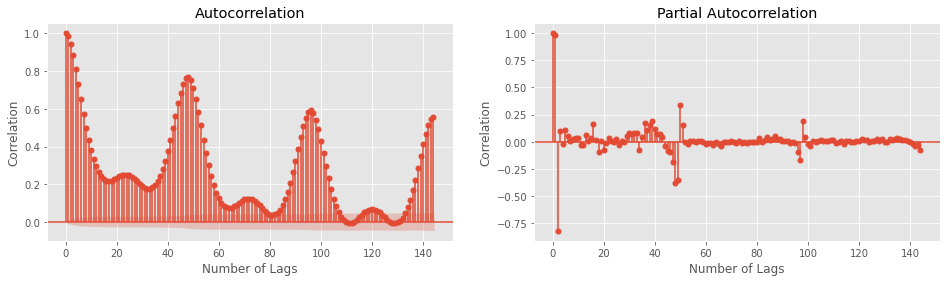

In [84]:
# Plot autocorrelation
nlags=144
plot_tsc(vic.demand_vic, lags=nlags)

In [85]:
# Add nlag features (choosing the first 10 highest autocorrelation nlag)
dict_pacf = dict()
list_pacf = pacf(df['demand_vic'], nlags=nlags)
for nlag in range(nlags):
    if nlag >= 48:
        dict_pacf[nlag] = list_pacf[nlag]
dict_pacf = {k: v for k, v in sorted(dict_pacf.items(), key=lambda item: abs(item[1]), reverse=True)}

# 10 highest pacf nlag
max_pacf_nlags = list(dict_pacf.keys())[:5]
for nlag in max_pacf_nlags:
    vic['n_lag'+str(nlag)] = df.reset_index()['demand_vic'].shift(nlag)

In [86]:
vic_train = vic[vic["time"] <= "2020-12-31 23:30:00"]
vic_cv = vic[(vic['time'] >= "2021-01-01 00:00:00") & (vic['time'] <= "2021-06-30 23:30:00")].reset_index(drop=True)
vic_test = vic[(vic['time'] >= "2021-07-01 00:00:00") & (vic['time'] <= "2021-08-11 23:30:00")].reset_index(drop=True)

In [87]:
X_train = vic_train.drop(columns=['demand_vic', 'time'])[nlags:]
y_train = vic_train.demand_vic[nlags:]
X_cv = vic_cv.drop(columns=['demand_vic', 'time'])
y_cv = vic_cv.demand_vic
X_test = vic_test.drop(columns=['demand_vic', 'time'])
y_test = vic_test.demand_vic
X_train.head(3)

,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,period,month,day,day_of_year,year,weekday,...,hour_cos1,hour_sin2,hour_cos2,hour_sin3,hour_cos3,n_lag48,n_lag49,n_lag50,n_lag98,n_lag97
144,51.34,70.67,36.45,40.14,1,1,4,4,2018,3,...,1.00,0.00,1.00,0.00,1.00,4624.00,4616.00,4379.00,4228.00,4429.00
145,44.23,65.33,28.75,49.63,2,1,4,4,2018,3,...,1.00,0.00,1.00,0.00,1.00,4444.00,4624.00,4616.00,4429.00,4436.00
146,32.16,65.34,31.98,53.46,3,1,4,4,2018,3,...,0.97,0.50,0.87,0.71,0.71,4296.00,4444.00,4624.00,4436.00,4259.00


In [88]:
X_train.columns

Index(['inter_gen_nsw', 'inter_gen_sa', 'inter_gen_tas', 'inter_gen_vic',
       'period', 'month', 'day', 'day_of_year', 'year', 'weekday', 'week',
       'hour', 'season', 'solar_exposure', 'year_sin1', 'year_cos1',
       'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'week_sin1',
       'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3',
       'hour_sin1', 'hour_cos1', 'hour_sin2', 'hour_cos2', 'hour_sin3',
       'hour_cos3', 'n_lag48', 'n_lag49', 'n_lag50', 'n_lag98', 'n_lag97'],
      dtype='object')

## 4) First look at Random Forest Regressor

In [91]:
rfr_clf = RandomForestRegressor(n_estimators=100)
rfr_clf = rfr_clf.fit(X_train, y_train)

Random Forest Regressor accuracy: 
Mean Absolute Percent Error: 0.0385
Root Mean Squared Error: 309.30059928202564


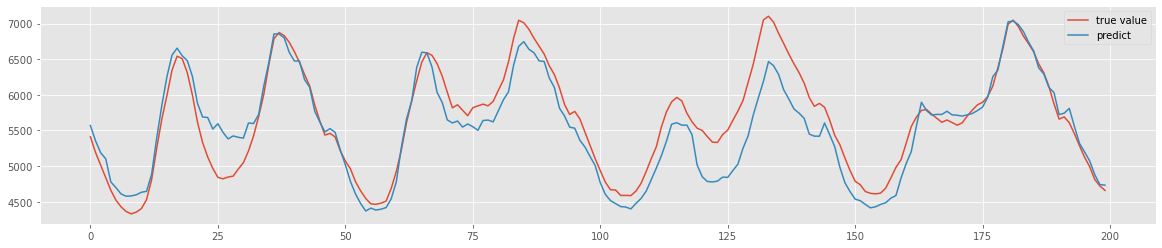

In [92]:
print("Random Forest Regressor accuracy: ")
rfr_result = rfr_clf.predict(X_test)
rfr_residuals = y_test - rfr_result
print('Mean Absolute Percent Error:', round(np.mean(abs(rfr_residuals/y_test)), 4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rfr_residuals**2)))

plt.figure(figsize=(20, 4))
plt.plot(y_test[:200], label='true value')
plt.plot(rfr_result[:200], label='predict')
plt.legend()
plt.show()

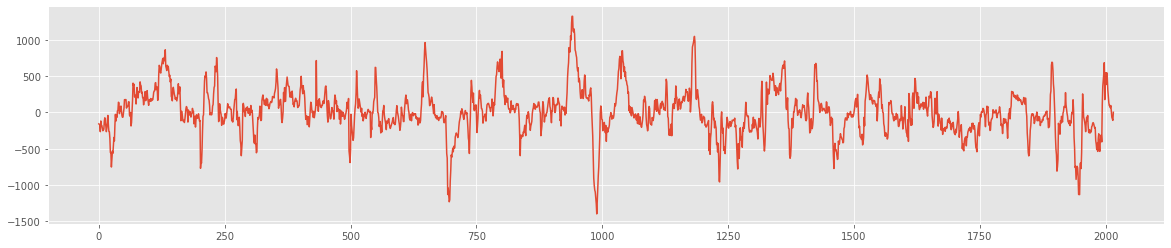

In [93]:
plt.figure(figsize=(20, 4))
plt.plot(rfr_residuals)
plt.show()

In [94]:
# Get numerical feature importances
importances = list(rfr_clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: n_lag48              Importance: 0.61
Variable: solar_exposure       Importance: 0.05
Variable: week_sin1            Importance: 0.04
Variable: period               Importance: 0.03
Variable: weekday              Importance: 0.03
Variable: year_cos1            Importance: 0.02
Variable: hour_cos1            Importance: 0.02
Variable: inter_gen_nsw        Importance: 0.01
Variable: inter_gen_sa         Importance: 0.01
Variable: inter_gen_tas        Importance: 0.01
Variable: inter_gen_vic        Importance: 0.01
Variable: day                  Importance: 0.01
Variable: day_of_year          Importance: 0.01
Variable: week                 Importance: 0.01
Variable: hour                 Importance: 0.01
Variable: year_sin1            Importance: 0.01
Variable: year_sin2            Importance: 0.01
Variable: year_cos2            Importance: 0.01
Variable: year_sin3            Importance: 0.01
Variable: year_cos3            Importance: 0.01
Variable: week_cos1            Importanc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## 6) Predict CV and Test period demand

### 6.1) Predict CV period demand

In [97]:
X_train = vic_train.drop(columns=['demand_vic', 'time'])[nlags:]
y_train = vic_train.demand_vic[nlags:]
X_cv = vic_cv.drop(columns=['demand_vic', 'time'])
y_cv = vic_cv.demand_vic

rfr_clf = RandomForestRegressor(n_estimators=100)
rfr_clf = rfr_clf.fit(X_train, y_train)

Random Forest Regressor accuracy: 
Mean Absolute Percent Error: 0.075
Root Mean Squared Error: 410.14593144350636


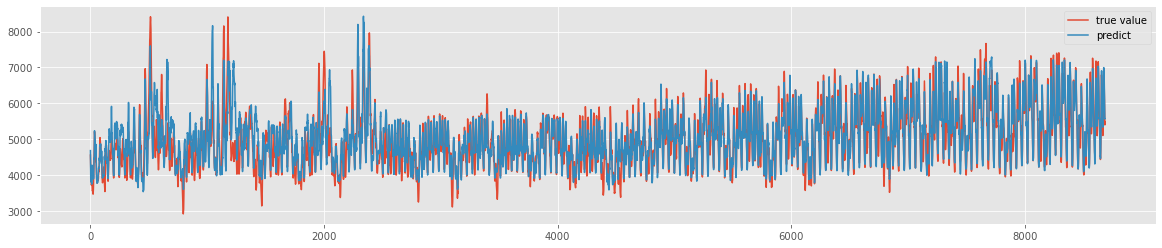

In [98]:
print("Random Forest Regressor accuracy: ")
rfr_result = rfr_clf.predict(X_cv)
rfr_residuals = y_cv - rfr_result
print('Mean Absolute Percent Error:', round(np.mean(abs(rfr_residuals/y_test)), 4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rfr_residuals**2)))

plt.figure(figsize=(20, 4))
plt.plot(y_cv, label='true value')
plt.plot(rfr_result, label='predict')
plt.legend()
plt.show()

In [101]:
vic_demand_cv_rfr = pd.DataFrame({'time': vic_cv.time, 'demand_vic': vic_cv.demand_vic})
vic_demand_cv_rfr['predicted_demand_vic'] = rfr_result
vic_demand_cv_rfr.tail(3)

,time,demand_vic,predicted_demand_vic
8685,2021-06-30 22:30:00,5653,5747.55
8686,2021-06-30 23:00:00,5397,5561.54
8687,2021-06-30 23:30:00,5487,5568.57


In [102]:
vic_demand_cv_rfr.to_csv('predictions/vic_demand_cv_rfr.csv', index=False, header=True)

### 6.2) Predict Test period demand

In [103]:
idx_test_start = 61296 # index of df(full) where test start
X_train = vic.drop(columns=['demand_vic', 'time'])[nlags:idx_test_start]
y_train = vic.demand_vic[nlags:idx_test_start]
X_test = vic_test.drop(columns=['demand_vic', 'time'])
y_test = vic_test.demand_vic

rfr_clf = RandomForestRegressor(n_estimators=100, random_state=1)
rfr_clf = rfr_clf.fit(X_train, y_train)

Random Forest Regressor accuracy: 
Mean Absolute Percent Error: 0.0383
Root Mean Squared Error: 308.43052357044763


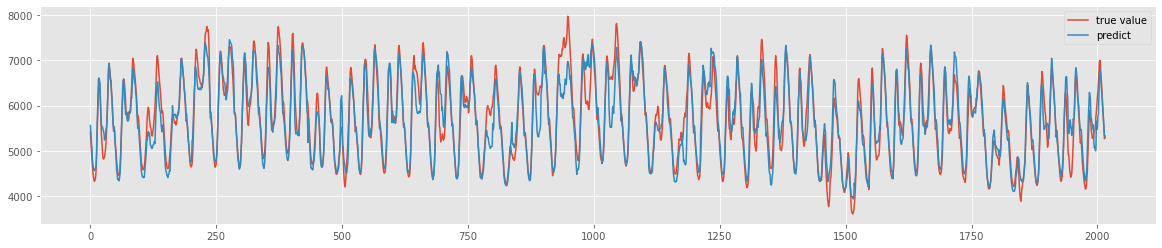

In [104]:
print("Random Forest Regressor accuracy: ")
rfr_result = rfr_clf.predict(X_test)
rfr_residuals = y_test - rfr_result
print('Mean Absolute Percent Error:', round(np.mean(abs(rfr_residuals/y_test)), 4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rfr_residuals**2)))

plt.figure(figsize=(20, 4))
plt.plot(y_test, label='true value')
plt.plot(rfr_result, label='predict')
plt.legend()
plt.show()

In [105]:
vic_demand_test_rfr = pd.DataFrame({'time': vic_test.time, 'demand_vic': vic_test.demand_vic})
vic_demand_test_rfr['predicted_demand_vic'] = rfr_result
vic_demand_test_rfr.tail(3)

,time,demand_vic,predicted_demand_vic
2013,2021-08-11 22:30:00,5450,5504.32
2014,2021-08-11 23:00:00,5269,5342.34
2015,2021-08-11 23:30:00,5332,5300.79


In [107]:
vic_demand_test_rfr.to_csv('predictions/vic_demand_test_rfr.csv', index=False, header=True)